In [1]:
import pandas as pd
import numpy as np
from tqdm import tqdm
from sklearn import model_selection
import statsmodels.api as sm
from sklearn.metrics import accuracy_score
import xgboost as xgb
import warnings
import matplotlib.pyplot as plt
import sys
sys.path.append('..')
warnings.filterwarnings('ignore')

from pyinform.blockentropy import block_entropy

In [2]:
path = 'C:/Users/camer/OneDrive/Documents/dev/home_research/data/volatility_prediction_optiver/'

In [3]:
book_train_all_stocks = []
for i in range(127):
    try:
        book_train = pd.read_parquet(path + 'book_train.parquet/stock_id=' + str(i))
        book_train['stock_id'] = i
        book_train_all_stocks.append(book_train)
        print('added stock', i)
    except: 
        continue
book_train_all_stocks = pd.concat(book_train_all_stocks)
print('completed_concatenation')
book_train_all_stocks

added stock 0
added stock 1
added stock 2
added stock 3
added stock 4
added stock 5
added stock 6
added stock 7
added stock 8
added stock 9
added stock 10
added stock 11
added stock 13
added stock 14
added stock 15
added stock 16
added stock 17
added stock 18
added stock 19
added stock 20
added stock 21
added stock 22
added stock 23
added stock 26
added stock 27
added stock 28
added stock 29
added stock 30
added stock 31
added stock 32
added stock 33
added stock 34
added stock 35
added stock 36
added stock 37
added stock 38
added stock 39
added stock 40
added stock 41
added stock 42
added stock 43
added stock 44
added stock 46
added stock 47
added stock 48
added stock 50
added stock 51
added stock 52
added stock 53
added stock 55
added stock 56
added stock 58
added stock 59
added stock 60
added stock 61
added stock 62
added stock 63
added stock 64
added stock 66
added stock 67
added stock 68
added stock 69
added stock 70
added stock 72
added stock 73
added stock 74
added stock 75
added

,time_id,seconds_in_bucket,bid_price1,ask_price1,bid_price2,ask_price2,bid_size1,ask_size1,bid_size2,ask_size2,stock_id
0,5,0,1.001422,1.002301,1.001370,1.002353,3,226,2,100,0
1,5,1,1.001422,1.002301,1.001370,1.002353,3,100,2,100,0
2,5,5,1.001422,1.002301,1.001370,1.002405,3,100,2,100,0
3,5,6,1.001422,1.002301,1.001370,1.002405,3,126,2,100,0
4,5,7,1.001422,1.002301,1.001370,1.002405,3,126,2,100,0
...,...,...,...,...,...,...,...,...,...,...,...
1042044,32767,588,0.999229,1.000051,0.999177,1.000103,100,200,28,100,126
1042045,32767,589,0.999229,1.000051,0.999177,1.000103,100,200,1,100,126
1042046,32767,590,0.999229,0.999794,0.999177,1.000051,101,27,1,200,126
1042047,32767,592,0.999229,0.999743,0.999177,1.000051,101,11,1,200,126


In [4]:
trade_train_all_stocks = []
for i in range(127):
    try:
        trade_train = pd.read_parquet(path + 'trade_train.parquet/stock_id=' + str(i))
        trade_train['stock_id'] = i
        trade_train_all_stocks.append(trade_train)
        print('added stock', i)
    except: 
        continue
trade_train_all_stocks = pd.concat(trade_train_all_stocks)
print('completed_concatenation')
trade_train_all_stocks.head()

added stock 0
added stock 1
added stock 2
added stock 3
added stock 4
added stock 5
added stock 6
added stock 7
added stock 8
added stock 9
added stock 10
added stock 11
added stock 13
added stock 14
added stock 15
added stock 16
added stock 17
added stock 18
added stock 19
added stock 20
added stock 21
added stock 22
added stock 23
added stock 26
added stock 27
added stock 28
added stock 29
added stock 30
added stock 31
added stock 32
added stock 33
added stock 34
added stock 35
added stock 36
added stock 37
added stock 38
added stock 39
added stock 40
added stock 41
added stock 42
added stock 43
added stock 44
added stock 46
added stock 47
added stock 48
added stock 50
added stock 51
added stock 52
added stock 53
added stock 55
added stock 56
added stock 58
added stock 59
added stock 60
added stock 61
added stock 62
added stock 63
added stock 64
added stock 66
added stock 67
added stock 68
added stock 69
added stock 70
added stock 72
added stock 73
added stock 74
added stock 75
added

,time_id,seconds_in_bucket,price,size,order_count,stock_id
0,5,21,1.002301,326,12,0
1,5,46,1.002778,128,4,0
2,5,50,1.002818,55,1,0
3,5,57,1.003155,121,5,0
4,5,68,1.003646,4,1,0


In [5]:
train_stock0 = pd.merge(book_train_all_stocks[book_train_all_stocks['stock_id']==0], trade_train_all_stocks[trade_train_all_stocks['stock_id']==0], on=['stock_id', 'time_id', 'seconds_in_bucket'], how='outer')
train_stock0.head()

,time_id,seconds_in_bucket,bid_price1,ask_price1,bid_price2,ask_price2,bid_size1,ask_size1,bid_size2,ask_size2,stock_id,price,size,order_count
0,5,0,1.001422,1.002301,1.00137,1.002353,3,226,2,100,0,NaN,NaN,NaN
1,5,1,1.001422,1.002301,1.00137,1.002353,3,100,2,100,0,NaN,NaN,NaN
2,5,5,1.001422,1.002301,1.00137,1.002405,3,100,2,100,0,NaN,NaN,NaN
3,5,6,1.001422,1.002301,1.00137,1.002405,3,126,2,100,0,NaN,NaN,NaN
4,5,7,1.001422,1.002301,1.00137,1.002405,3,126,2,100,0,NaN,NaN,NaN


In [6]:
# get target
train_target = pd.read_csv(path + 'train.csv')
train_target.head()

,stock_id,time_id,target
0,0,5,0.004136
1,0,11,0.001445
2,0,16,0.002168
3,0,31,0.002195
4,0,62,0.001747


In [113]:
train_stock0['mid_price'] = (train_stock0['bid_price1'] + train_stock0['ask_price1']) / 2
train_stock0.dropna()

,time_id,seconds_in_bucket,bid_price1,ask_price1,bid_price2,ask_price2,bid_size1,ask_size1,bid_size2,ask_size2,stock_id,price,size,order_count,mid_price,time,encoded_ret,log_ret,entropy
297,5,585,1.003129,1.003749,1.003025,1.003801,100,3,26,3,0,1.003646,26.0,2.0,1.003439,2085,4,0.000180,7.076816
326,11,131,0.999573,1.000376,0.999473,1.000527,38,40,200,150,0,0.999925,1.0,1.0,0.999975,3431,4,0.000000,6.409391
335,11,164,0.999925,1.000226,0.999875,1.000376,1,10,20,31,0,0.999990,29.0,3.0,1.000075,3464,4,-0.000125,7.851749
380,11,283,1.000176,1.000376,1.000126,1.000527,4,27,20,100,0,1.000376,5.0,1.0,1.000276,3583,4,0.000000,8.507795
420,11,383,1.000025,1.000527,0.999975,1.000678,137,200,303,28,0,1.000372,24.0,4.0,1.000276,3683,4,0.000126,8.499846
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32662,1209,176,0.994058,0.997772,0.993934,0.997833,100,100,105,100,0,0.995977,1.0,1.0,0.995915,362876,4,-0.000031,7.954196
32676,1209,199,0.997833,0.999567,0.996905,1.002724,101,14,400,100,0,0.999505,23.0,1.0,0.998700,362899,4,0.000031,7.954196
32690,1209,228,0.997895,0.999567,0.997462,1.002724,200,9,100,201,0,0.999567,3.0,1.0,0.998731,362928,4,0.000000,6.375039
32751,1209,365,0.999443,1.002352,0.999319,1.002724,400,100,5,152,0,1.000929,1.0,1.0,1.000898,363065,4,0.000000,7.622052


<Axes: xlabel='time'>

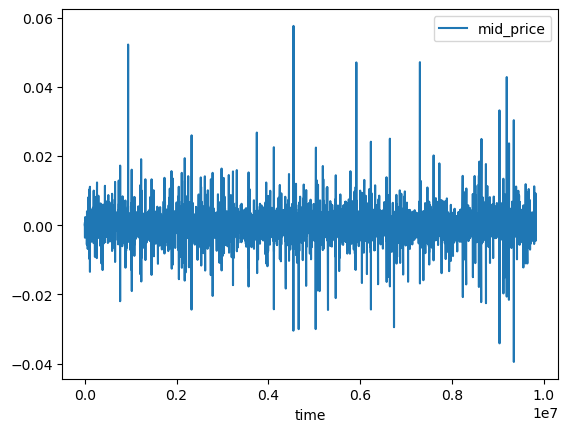

In [8]:
train_stock0['time'] = train_stock0['time_id'].astype(int)*60*5 + train_stock0['seconds_in_bucket']
train_stock0[['time', 'mid_price']].set_index('time').diff().plot()

In [9]:
from helper_functions.afml_functions.afml_modelling_lib import quantile_encode_series, shannon_entropy, encode_and_entropy

In [10]:
train_stock0['encoded_ret'] = quantile_encode_series(train_stock0['mid_price'].diff())

In [11]:
train_stock0['log_ret'] = np.log(train_stock0['mid_price']) - np.log(train_stock0['mid_price'].shift())

In [112]:
import itertools
best_rsqd = 0
best_qL = (2, 10)
for q, L in itertools.product([10, 15, 20], [10, 50, 100]):
    train_stock0['entropy'] = train_stock0[['time_id', 'log_ret']].dropna().groupby('time_id').apply(lambda x: shannon_entropy(quantile_encode_series(x['log_ret'], q).astype(str), L))
    stock0_entropy_target = pd.DataFrame(train_stock0['entropy'].dropna()).join(train_target[train_target['stock_id'] == 5].set_index('time_id')[['target']])
    mod = sm.OLS(stock0_entropy_target['target'], stock0_entropy_target[['entropy']])
    res = mod.fit()
    print(q, L, res.rsquared)
    best_rsqd = max(res.rsquared, best_rsqd)
    if res.rsquared == best_rsqd:
        best_qL = (q, L)
print(best_qL, best_rsqd)

10 10 0.6961620056778587
10 50 0.7399840250291163
10 100 0.7427781403626235
15 10 0.7188061164225883
15 50 0.7470045696165624
15 100 0.749122031587093
20 10 0.7284935216253363
20 50 0.7491446865802063
20 100 0.7506994923208291
(20, 100) 0.7506994923208291


### features to construct
(all should be averages with the interval of interest)
- diff between VWAP and midprice
- volume imbalance
- spread
- gradient of bid side book (bid_size_1 - bid_size2)/(bid_price_2 - bid_price_1)
- gradient of ask side book
- entropy contained in encoded fractionally differenced midprice
- entropy contained in fractionally differenced VWAP
- entropy in the differences
- average difference between trade price and ask (weighted by size)
- average difference between trade price and bid (weighted by size)
- previous vol at earlier steps (careful not to overlap)
- determinant of correlation matrix of returns inside the intervals (overall measure)
- vol is mean reverting - would be good to put some mean reverting ideas in here (

(calculate within a function to make life easier later!)